## Importing Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [2]:
df = pd.read_csv("resistive-sensor-raw.csv")
df.head()

,Timestamp,Temperature,Humidity,Moisture
0,8/5/2023 12:36:52,33.0,70,751
1,8/5/2023 12:37:01,33.0,70,751
2,8/5/2023 12:37:09,33.0,70,751
3,8/5/2023 12:37:18,33.0,70,751
4,8/5/2023 12:37:27,33.0,70,751


#### Column Meanings
<table>
    <head>
        <tr>
            <th>Column Name</th>
            <th>Description</th>
        </tr>
    </head>
    <body>
        <tr>
            <td>Timestamp</td>
            <td>When measurement was recorded</td>
        </tr>
        <tr>
            <td>Temperature</td>
            <td>Temperateure of air around plant in degrees Celsius</td>
        </tr>
        <tr>
            <td>Humidity</td>
            <td>Humidity of air around plant</td>
        </tr>
        <tr>
            <td>Moisture</td>
            <td>Lack of moisture in plant's soil on a scale of 247 to 1023</td>
        </tr>
    </body>
</table>

# Reading Data

In [3]:
df.describe()

,Temperature,Humidity,Moisture
count,8542.000000,8542.000000,8542.000000
mean,31.409412,76.219035,629.199251
std,2.042834,8.035348,89.482404
min,28.700000,42.000000,353.000000
25%,29.900000,70.000000,566.000000
50%,30.700000,80.000000,637.000000
75%,32.500000,82.000000,696.000000
max,43.500000,90.000000,988.000000


<AxesSubplot: title={'center': 'Moisture'}>

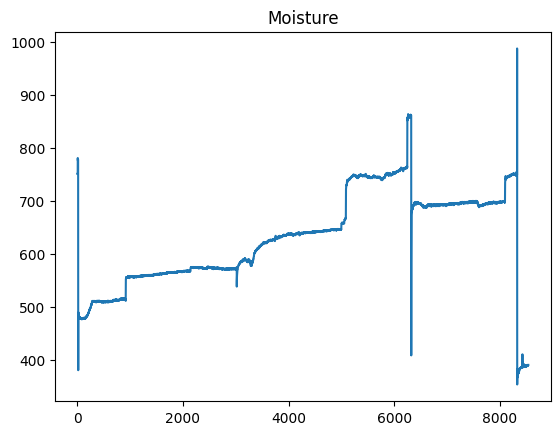

In [4]:
df["Moisture"].plot(title="Moisture")

<AxesSubplot: title={'center': 'Temperature'}>

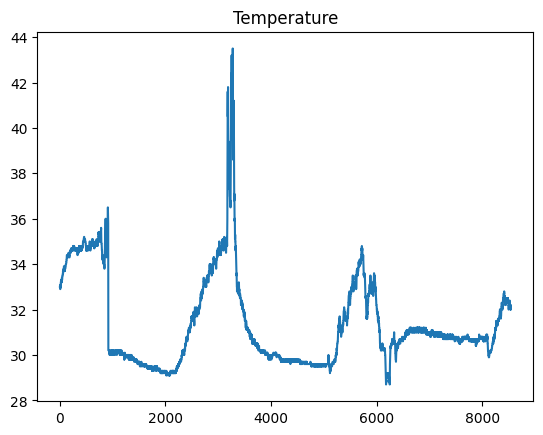

In [5]:
df["Temperature"].plot(title="Temperature")

<AxesSubplot: title={'center': 'Humidity'}>

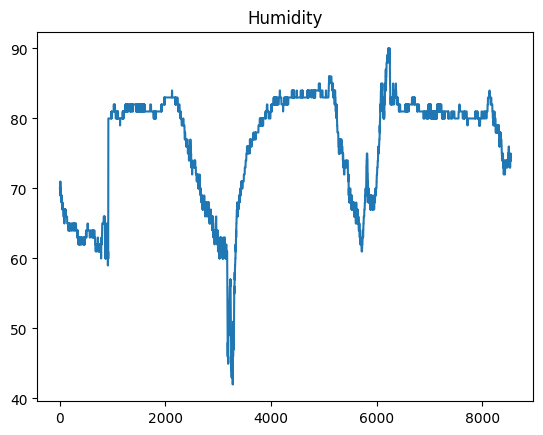

In [6]:
df["Humidity"].plot(title="Humidity")

In [7]:
df.corr(numeric_only=True)

,Temperature,Humidity,Moisture
Temperature,1.000000,-0.964963,-0.293088
Humidity,-0.964963,1.000000,0.357677
Moisture,-0.293088,0.357677,1.000000


Humidity and temperature have a really strong relationship.

## Modifying Data

### Timestamp

In [8]:
df["sTimestamp"] = df["Timestamp"] # timestamp as a string
df["Timestamp"] = pd.to_datetime(df["Timestamp"]) # timestamp as a datetime object
df["dTimestamp-1"] = (df["Timestamp"] - df["Timestamp"].shift(1)) / np.timedelta64(1, 's') # difference in seconds from last timestamp

Another column called `dTimestamp-1` was made to find the difference in time between recorded data.

In [9]:
df.head()

,Timestamp,Temperature,Humidity,Moisture,sTimestamp,dTimestamp-1
0,2023-08-05 12:36:52,33.0,70,751,8/5/2023 12:36:52,NaN
1,2023-08-05 12:37:01,33.0,70,751,8/5/2023 12:37:01,9.0
2,2023-08-05 12:37:09,33.0,70,751,8/5/2023 12:37:09,8.0
3,2023-08-05 12:37:18,33.0,70,751,8/5/2023 12:37:18,9.0
4,2023-08-05 12:37:27,33.0,70,751,8/5/2023 12:37:27,9.0


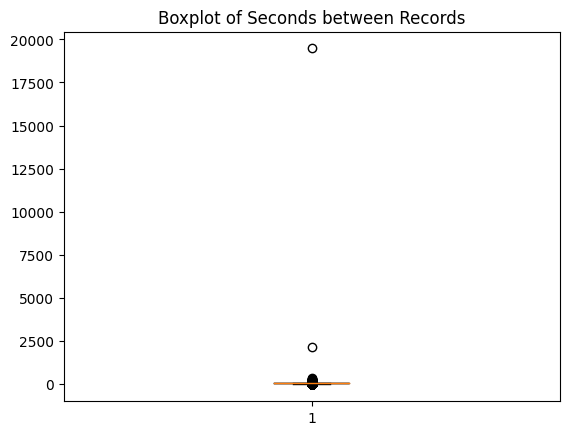

In [10]:
plt.boxplot(df[1:]["dTimestamp-1"])
plt.title("Boxplot of Seconds between Records")
plt.show()

In [11]:
df["dTimestamp-1"].nlargest(5)

916     19473.0
5085     2160.0
7         356.0
4238      317.0
5219      286.0
Name: dTimestamp-1, dtype: float64

The values of `dTimestamp-1` were not consistent. So, the recordings were compared to the recording made closest to 5 minutes before it.

In [12]:
df["Rows_Before"] = np.nan
df["dTimestamp"] = np.nan

In [13]:
dT1_loc = df.columns.get_loc("dTimestamp-1")
dT_loc = df.columns.get_loc("dTimestamp")
rows_before_loc = df.columns.get_loc("Rows_Before")

target_diff = 3600

for i in range(1, len(df)):
    rows_i_diff = 1
    time_diff_prev = 0
    time_diff_next = df.iloc[i, dT1_loc]
    final_diff = 0
    
    if time_diff_next > target_diff * 2: continue

    while time_diff_next < target_diff:
        time_diff_prev = time_diff_next
        rows_i_diff += 1
        time_diff_next += df.iloc[i - rows_i_diff + 1, dT1_loc]
    
    if time_diff_prev < target_diff - 30: continue
    if time_diff_prev > target_diff + 30: continue

    if abs(time_diff_next - target_diff) < abs(time_diff_prev - target_diff):
        final_diff = time_diff_next
    else:
        final_diff = time_diff_prev
        
    df.iloc[i, rows_before_loc] = rows_i_diff
    df.iloc[i, dT_loc] = final_diff

In [14]:
df.tail()

,Timestamp,Temperature,Humidity,Moisture,sTimestamp,dTimestamp-1,Rows_Before,dTimestamp
8537,2023-08-08 11:39:16,32.1,74,390,8/8/2023 11:39:16,29.0,126.0,3613.0
8538,2023-08-08 11:39:44,32.1,74,390,8/8/2023 11:39:44,28.0,126.0,3612.0
8539,2023-08-08 11:40:13,32.1,75,390,8/8/2023 11:40:13,29.0,126.0,3612.0
8540,2023-08-08 11:40:43,32.0,74,390,8/8/2023 11:40:43,30.0,126.0,3613.0
8541,2023-08-08 11:41:12,32.1,74,390,8/8/2023 11:41:12,29.0,126.0,3613.0


(array([  14.,   21.,   27.,  830.,  775.,  975., 1375., 2276., 1281.,
          97.]),
 array([3570. , 3574.8, 3579.6, 3584.4, 3589.2, 3594. , 3598.8, 3603.6,
        3608.4, 3613.2, 3618. ]),
 <BarContainer object of 10 artists>)

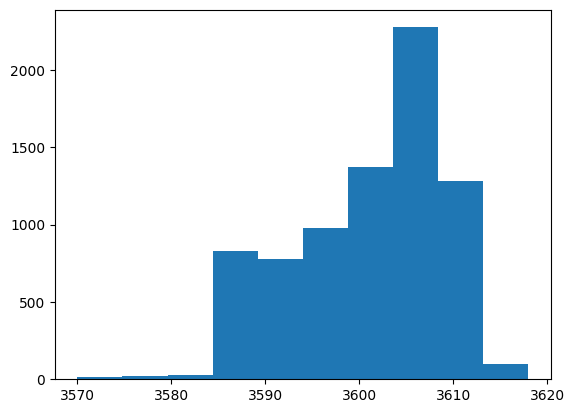

In [15]:
plt.hist(df["dTimestamp"])

In [16]:
len(df.dropna())

7671

In [17]:
df.describe()

,Temperature,Humidity,Moisture,dTimestamp-1,Rows_Before,dTimestamp
count,8542.000000,8542.000000,8542.000000,8541.000000,7671.000000,7671.000000
mean,31.409412,76.219035,629.199251,29.956680,139.507365,3601.055143
std,2.042834,8.035348,89.482404,212.066227,64.079291,7.941619
min,28.700000,42.000000,353.000000,-29.000000,52.000000,3570.000000
25%,29.900000,70.000000,566.000000,28.000000,123.000000,3595.000000
50%,30.700000,80.000000,637.000000,28.000000,127.000000,3603.000000
75%,32.500000,82.000000,696.000000,29.000000,128.000000,3607.000000
max,43.500000,90.000000,988.000000,19473.000000,412.000000,3618.000000


### Moisture

Moisture content is expressed in percentage. Unlike the values in the dataframe, moisture content is directly proportional to the amount of moisture in the soil. So, the moisture column was modified.

When the sensor is in air, it outputs a value of `1023`. When in the water, it outputs a minimum value of `247`. So, the formula for moisture sensor is the formula

$M_c = 1 - \frac{M_ s - 247}{1023 - 247}$

where $M_c$ is the moisture content and $M_s$ is the value from the sensor.

In [18]:
df["Moisture"] = 1 - ((df["Moisture"] - 247) / (1023 - 247))

In [19]:
df["dMoisture"] = np.nan

In [20]:
moisture_loc = df.columns.get_loc("Moisture")
dMoisture_loc = df.columns.get_loc("dMoisture")
rows_bef_loc = df.columns.get_loc("Rows_Before")

for i in range(1, len(df)):
    rows_before = df.iloc[i]["Rows_Before"]
    
    if np.isnan(rows_before): continue
    rows_before = int(rows_before)
    
    df.iloc[i, dMoisture_loc] = df.iloc[i, moisture_loc] - df.iloc[i - rows_before, moisture_loc]

In [21]:
df.tail()

,Timestamp,Temperature,Humidity,Moisture,sTimestamp,dTimestamp-1,Rows_Before,dTimestamp,dMoisture
8537,2023-08-08 11:39:16,32.1,74,0.815722,8/8/2023 11:39:16,29.0,126.0,3613.0,-0.006443
8538,2023-08-08 11:39:44,32.1,74,0.815722,8/8/2023 11:39:44,28.0,126.0,3612.0,-0.006443
8539,2023-08-08 11:40:13,32.1,75,0.815722,8/8/2023 11:40:13,29.0,126.0,3612.0,-0.006443
8540,2023-08-08 11:40:43,32.0,74,0.815722,8/8/2023 11:40:43,30.0,126.0,3613.0,-0.006443
8541,2023-08-08 11:41:12,32.1,74,0.815722,8/8/2023 11:41:12,29.0,126.0,3613.0,-0.006443


### Finding Temperature that Caused Moisture Change

In [22]:
df["Cause_Temperature"] = np.nan

In [23]:
rows_bef_loc = df.columns.get_loc("Rows_Before")
temp_loc = df.columns.get_loc("Temperature")
ctemp_loc = df.columns.get_loc("Cause_Temperature")

for i in range(1, len(df)):
    rows_before = df.iloc[i]["Rows_Before"]
    
    if np.isnan(rows_before): continue
    rows_before = int(rows_before)
    
    df.iloc[i, ctemp_loc] = df.iloc[i - rows_before, temp_loc]

In [24]:
df.tail()

,Timestamp,Temperature,Humidity,Moisture,sTimestamp,dTimestamp-1,Rows_Before,dTimestamp,dMoisture,Cause_Temperature
8537,2023-08-08 11:39:16,32.1,74,0.815722,8/8/2023 11:39:16,29.0,126.0,3613.0,-0.006443,32.7
8538,2023-08-08 11:39:44,32.1,74,0.815722,8/8/2023 11:39:44,28.0,126.0,3612.0,-0.006443,32.7
8539,2023-08-08 11:40:13,32.1,75,0.815722,8/8/2023 11:40:13,29.0,126.0,3612.0,-0.006443,32.7
8540,2023-08-08 11:40:43,32.0,74,0.815722,8/8/2023 11:40:43,30.0,126.0,3613.0,-0.006443,32.7
8541,2023-08-08 11:41:12,32.1,74,0.815722,8/8/2023 11:41:12,29.0,126.0,3613.0,-0.006443,32.7


### Delete Rows with Null Values
After processing the data, the data with null values are deleted.

In [25]:
len(df.dropna())

7671

In [26]:
df = df.dropna()
df.head()

,Timestamp,Temperature,Humidity,Moisture,sTimestamp,dTimestamp-1,Rows_Before,dTimestamp,dMoisture,Cause_Temperature
371,2023-08-05 13:36:25,34.8,62,0.661082,8/5/2023 13:36:25,9.0,372.0,3573.0,-0.154639,32.1
372,2023-08-05 13:36:34,34.8,62,0.661082,8/5/2023 13:36:34,9.0,373.0,3582.0,-0.154639,32.1
373,2023-08-05 13:36:43,34.8,62,0.661082,8/5/2023 13:36:43,9.0,374.0,3591.0,-0.154639,32.1
374,2023-08-05 13:36:51,34.7,62,0.661082,8/5/2023 13:36:51,8.0,375.0,3599.0,-0.154639,32.1
375,2023-08-05 13:36:59,34.8,62,0.662371,8/5/2023 13:36:59,8.0,375.0,3598.0,0.311856,33.0


### Deleting Outliers in `dMoisture`
During the experiment, there were times when I pulled out the moisture sensor or switched its polarities. There were also times when I watered the plant during the experiment. So, it is important to remove the outliers where `dMoisture` is too high or too low.

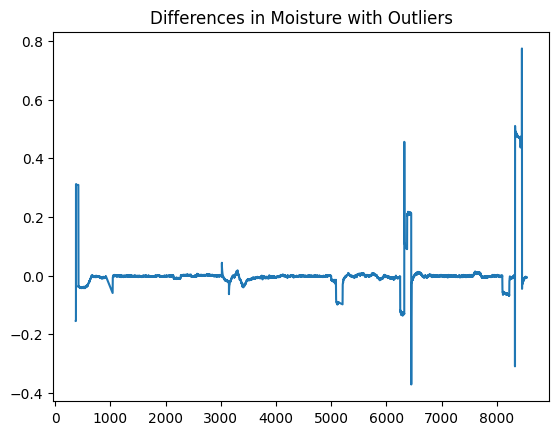

In [27]:
plt.plot(df["dMoisture"])
plt.title("Differences in Moisture with Outliers")
plt.show()

In [28]:
d_moisture_stats = df[["dMoisture"]].describe()
d_moisture_stats

,dMoisture
count,7671.000000
mean,0.003628
std,0.067844
min,-0.371134
25%,-0.006443
50%,-0.002577
75%,0.000000
max,0.774485


In [29]:
d_moisture_25 = d_moisture_stats.iloc[4,0]
d_moisture_75 = d_moisture_stats.iloc[6,0]
(d_moisture_25, d_moisture_75)

(-0.006443298969072142, 0.0)

After these outliers are removed, 4640 rows remain. This number of rows is only <b>54%</b> of the original data, but the remaining data can still be used in the data analysis. 

In [30]:
len(df[(df["dMoisture"] <= d_moisture_75) & (df["dMoisture"] >= d_moisture_25)])

4640

In [31]:
df = df[(df["dMoisture"] <= d_moisture_75) & (df["dMoisture"] >= d_moisture_25)]

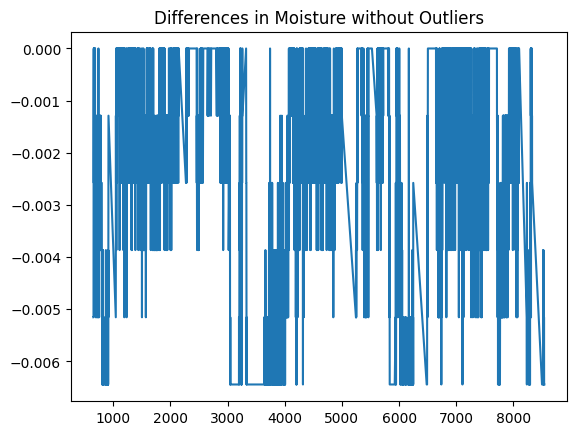

In [32]:
plt.plot(df["dMoisture"])
plt.title("Differences in Moisture without Outliers")
plt.show()

### Removing Columns to Clean Data Further

In [33]:
df.head()

,Timestamp,Temperature,Humidity,Moisture,sTimestamp,dTimestamp-1,Rows_Before,dTimestamp,dMoisture,Cause_Temperature
651,2023-08-05 14:21:37,34.8,64,0.661082,8/5/2023 14:21:37,10.0,380.0,3599.0,-0.005155,34.7
652,2023-08-05 14:21:47,34.7,64,0.661082,8/5/2023 14:21:47,10.0,379.0,3600.0,-0.005155,34.7
653,2023-08-05 14:21:57,34.7,64,0.661082,8/5/2023 14:21:57,10.0,379.0,3602.0,-0.005155,34.7
654,2023-08-05 14:22:11,34.8,64,0.661082,8/5/2023 14:22:11,14.0,379.0,3599.0,-0.001289,34.7
655,2023-08-05 14:22:20,34.8,64,0.661082,8/5/2023 14:22:20,9.0,379.0,3599.0,0.000000,34.6


In [34]:
# df = df[["Timestamp", "dMoisture", "Cause_Temperature"]]
df[["Timestamp", "dMoisture", "Cause_Temperature"]].to_csv("resistive-sensor-clean.csv", index=False)